In [11]:
from xopto.mcml import mc
from xopto.cl import clinfo
from xopto.materials.absorption import oxyhem, deoxyhem

import numpy as np
import matplotlib.pyplot as pp

In [12]:
cl_device = clinfo.gpu()

In [13]:
# DEFINE RELEVANT SIMULATION PARAMETERS
nphotons = 1e6
wavelengths = np.arange(450e-9, 801e-9, 2e-9)

# DEFINE OPTICAL PROPERTIES FOR TWO-LAYERED HUMAN SKIN

In [14]:
# layer 1 - EPIDERMIS
d1 = 100e-6  # layer thickness in m
n1 = 1.4  # refractive index
m = 0.02  # melanin volume fraction
g1 = 0.8  # anisotropy factor constant with wavelength
pf1 = mc.mcpf.Hg(g1)  # Henyey-Greenstein scattering phase function

# epidermis absortpion coefficient
mua1 = lambda wavelength: m * 6.6*1e13*(1e9*wavelength)**-3.33 + \
    (1-m) * 1e2*0.5*(0.244 + 85.3*np.exp(-(1e9*wavelength - 154)/66.2))

# epidermis scattering coefficient
mus1 = lambda wavelength: (2*1e7*(1e9*wavelength)**-1.5 + \
    2*1e14*(1e9*wavelength)**-4) / (1-g1)

In [15]:
# layer 2 - DERMIS
d2 = 10e-3  # layer thickness in m
n2 = 1.4  # refractive index
bl = 0.02  # blood volume fraction
oxy = 0.90  # oxygenation
g2 = 0.8  # anisotropy factor
pf2 = mc.mcpf.Hg(g2)  # Henyey-Greenstein scattering phase function

# dermis absorption coefficient
mua_oxy = oxyhem.OxyHem()
mua_deoxy = deoxyhem.DeOxyHem()

mua2 = lambda wavelength: bl * (oxy * mua_oxy(wavelength, None) + \
    (1-oxy) * mua_deoxy(wavelength, None)) + \
    (1-bl) * 1e2 * (0.244 + 16.82*np.exp(-(1e9*wavelength - 400) / 80.5))

# dermis scattering coefficient
mus2 = lambda wavelength: (2*1e7*(1e9*wavelength)**-1.5 + \
    2*1e14*(1e9*wavelength)**-4) / (1-g2)

In [16]:
# DEFINE TWO-LAYERED SKIN MODEL LAYER STACK
layers = mc.mclayer.Layers([
    mc.mclayer.Layer(d=0.0, n=1.0, mua=0.0, mus=0.0, pf=pf1),  # layer above the medium
    mc.mclayer.Layer(d=d1, n=n1, mua=1.0e2, mus=1.0e2, pf=pf1),
    mc.mclayer.Layer(d=d2, n=n2, mua=1.0e2, mus=1.0e2, pf=pf2),
    mc.mclayer.Layer(d=0.0, n=1.0, mua=0.0, mus=0.0, pf=pf1),  # layer below the medium
])

In [17]:
# DEFINE SOURCE
source = mc.mcsource.Line(
    position=(0.0, 0.0, 0.0),
    direction=(0.0, 0.0, 1.0)
)

# DEFINE A DETECTOR FOR INTEGRATING SPHERE
sp_r = 0.5e-2  # integrating sphere opening in m
detector_top = mc.mcdetector.Radial(
    mc.mcdetector.RadialAxis(
        start=0.0,
        stop=2*sp_r,
        n=2)
)
detectors = mc.mcdetector.Detectors(
    top=detector_top
)

In [18]:
# DEFINE THE MC OBJECT FOR SIMULATIONS
mc_obj = mc.Mc(
    layers=layers, 
    source=source,
    detectors=detectors, 
    cl_devices=cl_device
)
mc_obj.rmax = 10e-2

In [19]:
# DO SIMULATIONS FOR DESIRED WAVELENGTH RANGE
reflectance_spectrum = np.zeros_like(wavelengths)
for i, w in enumerate(wavelengths):

    # for each wavelength redefine optical properties
    mc_obj.layers[1].mua = mua1(w)
    mc_obj.layers[1].mus = mus1(w)
    mc_obj.layers[2].mua = mua2(w)
    mc_obj.layers[2].mus = mus2(w)

    detector = mc_obj.run(nphotons, verbose=True)[-1]
    reflectance_spectrum[i] = detector.top.reflectance[0] * np.pi * sp_r**2

OpenCL source files fused in 20.435096 ms.
Executing OpenCL code on: [<pyopencl.Device 'Intel(R) Iris(R) Xe Graphics' on 'Intel(R) OpenCL Graphics' at 0x568abf91aa70>]
OpenCL build options: []
Source code built in 586.217 ms.
OpenCL engine created in 669.106 ms.
McKernel processed 1,000,000 packets in 9,984 threads:
    uploaded/built in:    687.006 ms
    executed in      :     48.405 ms
    downloaded in    :      1.617 ms
McKernel processed 1,000,000 packets in 9,984 threads:
    uploaded/built in:      1.967 ms
    executed in      :     48.611 ms
    downloaded in    :      1.153 ms
McKernel processed 1,000,000 packets in 9,984 threads:
    uploaded/built in:      2.054 ms
    executed in      :     51.517 ms
    downloaded in    :      0.537 ms


/home/mikhail/Projects/Skoltech/Biophotonics/light-in-skin-animation/pyxopto/xopto/mcbase/mcworker.py:520: RepeatedKernelRetrieval: Kernel 'fill_uint64' has been retrieved more than once. Each retrieval creates a new, independent kernel, at possibly considerable expense. To avoid the expense, reuse the retrieved kernel instance. To avoid this warning, use cl.Kernel(prg, name).
  cl_kernel = getattr(self.cl_exec, kernel_name, None)
/home/mikhail/Projects/Skoltech/Biophotonics/light-in-skin-animation/pyxopto/xopto/mcml/mc.py:922: RepeatedKernelRetrieval: Kernel 'McKernel' has been retrieved more than once. Each retrieval creates a new, independent kernel, at possibly considerable expense. To avoid the expense, reuse the retrieved kernel instance. To avoid this warning, use cl.Kernel(prg, name).
  self._cl_exec.McKernel(


McKernel processed 1,000,000 packets in 9,984 threads:
    uploaded/built in:      1.041 ms
    executed in      :     51.558 ms
    downloaded in    :      0.891 ms
McKernel processed 1,000,000 packets in 9,984 threads:
    uploaded/built in:      1.297 ms
    executed in      :     49.830 ms
    downloaded in    :      1.168 ms
McKernel processed 1,000,000 packets in 9,984 threads:
    uploaded/built in:      4.500 ms
    executed in      :     52.931 ms
    downloaded in    :      0.778 ms
McKernel processed 1,000,000 packets in 9,984 threads:
    uploaded/built in:      2.838 ms
    executed in      :     51.009 ms
    downloaded in    :      0.922 ms
McKernel processed 1,000,000 packets in 9,984 threads:
    uploaded/built in:      2.989 ms
    executed in      :     54.505 ms
    downloaded in    :      1.073 ms
McKernel processed 1,000,000 packets in 9,984 threads:
    uploaded/built in:      2.635 ms
    executed in      :     53.828 ms
    downloaded in    :      1.177 ms
McKe

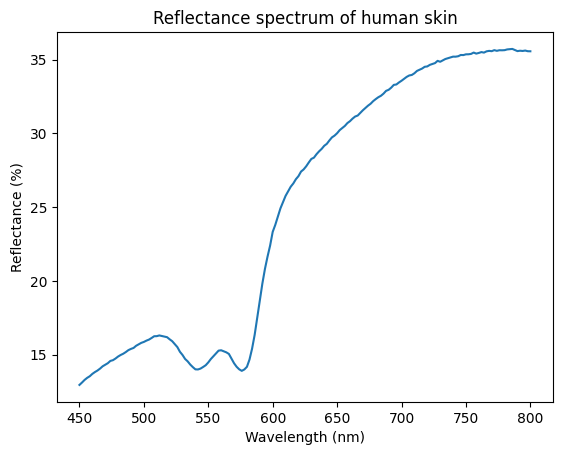

In [20]:
# PLOT THE REFLECTANCE SPECTRUM
pp.figure()
pp.title('Reflectance spectrum of human skin')
pp.plot(1e9*wavelengths, 100*reflectance_spectrum)
pp.xlabel('Wavelength (nm)')
pp.ylabel('Reflectance (%)')
pp.show()